In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import re
from itertools import chain
from collections import Counter
import collections
import torch.nn as nn
from bs4 import BeautifulSoup
import requests
from bs4.element import Comment
import glob
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertModel, logging
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset, random_split
from tqdm import tqdm
import time
import sys
import spacy
from selenium import webdriver

#nlp = spacy.load("en_core_web_trf") # does not work with .oov_
nlp = spacy.load("en_core_web_lg")

sys.path.insert(0, '../src/models/')
sys.path.insert(0, '../src/features/')

from predict_model import loadBERT
from predict_model import SpanPredictor as classify
from build_features import text_cleaner, DuckDuckGo_Java, Bing_HTML, colorize_prediction


logging.set_verbosity_warning()

%matplotlib inline

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- T

In [2]:
model = loadBERT("../models/", 'saved_weights_inf_FIXED_boot_beta80.pt')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

CPU Success


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# Preprocessing

### Birds used in the CUB dataset

In [4]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/classes.txt"
with open(location) as f:
    lines = f.readlines()

In [5]:
# Init regex
regex = r'\d+\s\d+\.'
# Clean the list
CUB = [re.sub(regex, '', line).rstrip().replace('_', ' ') for line in lines]

In [6]:
# Read the BOWO list to compare names
# Read all html locations
BOWO_folder_list = glob.glob('../data/raw/BOW/*')
# Create BOW list with large descriptions
BOWO_folder_list_large = [birds for birds in BOWO_folder_list if len(glob.glob(birds + '/*')) > 1]
# Clean the lists
BOW_all = [bird[16:] for bird in BOWO_folder_list]
BOW_large = [bird[16:] for bird in BOWO_folder_list_large]

In [7]:
# Intersect common names
common_birds = list(set(CUB) & set(BOW_all))
# Random sample so the CUB is about 5%
birds_list = list(set(BOW_large + common_birds))

### Birds Glossary

In [8]:
# URL
URL = 'https://en.wikipedia.org/wiki/Glossary_of_bird_terms'
# Get the page
page = requests.get(URL, timeout=5)
soup = BeautifulSoup(page.content, "lxml", from_encoding="iso-8859-1")   
# Find embedded glossary
glossaries = soup.find_all('dt', {'class': 'glossary'})
parts = [part.text.lower().strip() for part in glossaries]
# Get additional anchors ("also know as...")
glossaries_other = soup.find_all('span', {'class': 'anchor'})
parts_other = [part['id'].lower().strip() for part in glossaries_other]
# Append and drop duplicates
parts = list(set((parts + parts_other)))
# Replace underscore with space
parts = [part.replace('_', ' ') for part in parts]

In [9]:
parts.index('wind eggs')

768

### BOW HTMLS
Open the Birds of the Worlds HTMLS that correspond to the UCB dataset and get the descriptions out using the trained classifier.

In [ ]:
# Rejoin the location
birds_location = ['../data/raw/BOW/' + bird for bird in birds_list]

In [ ]:
# Init dict for storage
birds_dict = collections.defaultdict(list)

for bird_loc in tqdm(birds_location[0:]):
    # Get the name
    BIRD = bird_loc[16:]
    # Check the amount of account
    if len(glob.glob(bird_loc + '/*')) > 1:
        # Construct the HTML
        HTML = bird_loc + '/Appearance.html'
    else:
        HTML = bird_loc + '/Introduction.html'
    # Open the HTML
    with open(HTML) as f:
        # Structure it
        soup = BeautifulSoup(f, 'html.parser')
        # Get all spans
        spans = [span for span in soup.find_all('p') 
                 if not 'fig' in span.text]
        for span in spans:
            # Remove double whitespace
            # Clean citations with a nested expression
            text = re.sub(r"\s+", " ", span.text)
            text = re.sub(r'\(\d+?\w\)', '###', text)
            text = re.sub(r'\([^)]*\)', '', text)
            # Replace ; with . to help the sentecizer
            text = text.replace(';', '.')
            # NLP
            doc = nlp(text)
            for sent in doc.sents:    
                # Skip short sents
                if len(sent) <= 4:
                    continue
                # Check amount of non-english
                non_eng = [token.is_oov for token in sent].count(True)
                # Skip if the ratio is above .2
                if non_eng > 0 and non_eng / len(sent) > .2:
                    continue
                # Also skip if the non-eng is large
                if non_eng > 8:
                    continue
                # Check classification
                if classify(sent.text, model=model):
                    birds_dict[BIRD].append(sent.text)

In [ ]:
print(len(birds_dict.values()))

In [ ]:
# Dump the file into a pickle
with open('../data/description/04_TRAIN_0-1881_BIRDS.pkl', 'wb') as f:
    pickle.dump(birds_dict, f)

## Select Trait sentences
Split the sentence on the comma to create cleaner chunk for comparison

In [10]:
bird_descriptions_random_dict = pickle.load(open('../data/description/03_DESC_0000000-0001881_BIRDS.pkl', 'rb'))
bird_descriptions_BOW_dict = pickle.load(open('../data/description/03_BOW_0000000-0001881_BIRDS.pkl', 'rb'))

In [11]:
# Init dict for storage
bird_dict = collections.defaultdict(list)
for bird in tqdm(bird_descriptions_BOW_dict.keys()):
    for sentence in bird_descriptions_BOW_dict[bird]:
        bird_dict[bird].append(sentence)
for bird in tqdm(bird_descriptions_random_dict.keys()):
    for sentence in bird_descriptions_random_dict[bird]:
        bird_dict[bird].append(sentence)    

100%|███████████████████████████████████| 1674/1674 [00:00<00:00, 125693.97it/s]


In [ ]:
# Dump the file into a pickle
with open('../data/description/04_TRAIN_0000000-0001881_BIRDS.pkl', 'wb') as f:
    pickle.dump(bird_dict, f)

In [ ]:
# Init dict for storage
bird_traits_dict = collections.defaultdict(list)
bird_traits_chunk_dict = collections.defaultdict(list)


for bird in tqdm(bird_dict.keys()):
    for sentence in bird_dict[bird]:
        doc = nlp(sentence)
        # Check single
        words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
        # Check multiple
        words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
        # Drop duplicate
        words = list(set(words))
        # Intersect
        traits =  set(words) & set(parts)
        if traits:
            bird_traits_dict[bird].append(sentence)
            
        # Also create chunks to see if this works better
        for part in sentence.split(','):
            # Clean
            part = part.strip()
            # Skip single words
            if len(part.split()) <= 2:
                continue
            doc = nlp(part)
            # Check single
            words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
            # Check multiple
            words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
            # Drop duplicate
            words = list(set(words))
            # Intersect
            traits =  set(words) & set(parts)
            if traits:
                bird_traits_chunk_dict[bird].append(part)            

In [ ]:
# Dump the file into a pickle
with open('../data/description/04_TRAIN_0000000-0001881_TRAITS_BIRDS.pkl', 'wb') as f:
    pickle.dump(bird_traits_dict, f)
# Dump the file into a pickle
with open('../data/description/04_TRAIN_0000000-0001881_TRAITS_CHUNK_BIRDS.pkl', 'wb') as f:
    pickle.dump(bird_traits_chunk_dict, f)

Plot some additional statistics: comparison between all description data and data in the glossary

In [12]:
bird_descriptions_dict = pickle.load(open('../data/description/04_TRAIN_0000000-0001881_BIRDS.pkl', 'rb'))
bird_traits_dict = pickle.load(open('../data/description/04_TRAIN_0000000-0001881_TRAITS_BIRDS.pkl', 'rb'))
bird_traits_chunk_dict = pickle.load(open('../data/description/04_TRAIN_0000000-0001881_TRAITS_CHUNK_BIRDS.pkl', 'rb'))

In [13]:
# Count
description_count = [len(values) for values in bird_dict.values()]
trait_count = [len(values) for values in bird_traits_dict.values()]
trait_chunk_count = [len(values) for values in bird_traits_chunk_dict.values()]


# Zip the lists
data_tuples = list(zip(description_count, trait_count, trait_chunk_count))
# And put in a df
df = pd.DataFrame(data_tuples, columns=['Description','Trait', 'Trait_chunk'])
# Melt the df
df_melt = df.melt(value_vars=['Description', 'Trait', 'Trait_chunk'])

<AxesSubplot:ylabel='Frequency'>

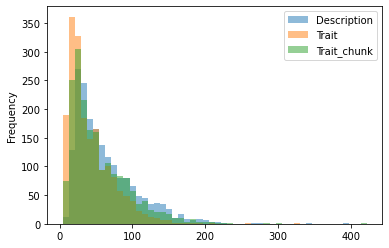

In [15]:
df.plot.hist(bins=50, alpha=0.5,)

# Train a Model

In [ ]:
#data = pickle.load(open('../data/description/04_TRAIN_0000000-0001881_TRAITS_BIRDS.pkl', 'rb'))

In [16]:
# Define the model
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()

        # Distil Bert model
        self.bert = bert
        ## Additional layers
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        # Relu 
        self.relu =  nn.ReLU()
        # Linear I 
        self.fc1 = nn.Linear(768, 512)
        # Linear II (Out)
        self.fc2 = nn.Linear(512, 1881) # Some species where lost
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)


    # Forward pass
    def forward(self, **kwargs):
        # Pass data trough bert and extract 
        cls_hs = self.bert(**kwargs)
        # Extract hidden state
        hidden_state = cls_hs.last_hidden_state
        # Only first is needed for classification
        pooler = hidden_state[:, 0]
        # Dense layer 1        
        x = self.fc1(pooler)
        # ReLU activation
        x = self.relu(x)
        # Drop out
        x = self.dropout(x)
        # Dense layer 2
        x = self.fc2(x)
        # Activation
        x = self.softmax(x)

        return x

In [17]:
# Load the entire model
model = BERT(bert)

# Load pretrained model (colab)
try:
    try:
        #model_save_name = 'saved_weights_CUB.pt'
        model_save_name = 'saved_weights_CUB_CHUNKS.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}"
        model.load_state_dict(torch.load(path))
        print('Google Success')

    except:
        #model_save_name = 'saved_weights_CUB.pt'
        model_save_name = 'saved_weights_CUB_CHUNKS.pt'
        path = "../models/" + model_save_name
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        print('Local Success')
except:
    print('No pretrained model found.')

# Push the model to GPU (if available)
model = model.to(device)
model.eval()
model.zero_grad()

Local Success


# Interpretability

In [18]:
from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
from captum.attr import Occlusion
from spacy import displacy
# Load transformer module
nlp = spacy.load("en_core_web_trf")

In [19]:
# Set seeds
torch.manual_seed(333)
np.random.seed(333)

### Functions used for determining interpretability

In [20]:
# Modify the prediction output and define a custom forward
def predict(inputs):
    return model(input_ids=inputs, attention_mask=attention_mask)[0]

def custom_forward(inputs):
    preds = predict(inputs)
    return torch.exp(preds)

# Tokenize functions
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

# Summarize and vis functions
def summarize_attributions_ig(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def summarize_attributions_occ(attributions):
    return attributions.sum(axis=0)

def token_to_words(attribution, tokens):
    
    words = []
    attributes = []

    for attribute, word in zip(attribution, tokens):

        attribute = attribute.cpu().detach().numpy()
        if word == '[CLS]' or word == '[SEP]':
            words.append(word)
            attributes.append([attribute])
        elif not word.startswith('##'):
            words.append(word)
            attributes.append([attribute])
        elif word.startswith('##'):
            words[-1] += word.strip('##')
            attributes[-1] = np.append(attributes[-1], attribute)

    attribution = [np.sum(mean) for mean in attributes]
    return attribution, words

def colorize(attribution, tokens):
    
    template = """  
    <mark class="entity" style="
    background: {}; 
    padding: 0.4em 0.0em; 
    margin: 0.0em; 
    line-height: 2; 
    border-radius: 0.0em;
    ">{}<span style="
    font-size: 0.8em; 
    font-weight: bold; 
    line-height: 1; 
    border-radius: 0.0em;   
    text-align-last:center;
    vertical-align: middle;
    margin-left: 0rem;
    "></span></mark>
    """

    colored_string = ''
    normalized_and_mapped = matplotlib.cm.ScalarMappable(cmap=matplotlib.cm.Greens).to_rgba(attribution)
    for idx, (word, color) in enumerate(zip(tokens, normalized_and_mapped)):
        
        word = word + ' '
        color = matplotlib.colors.rgb2hex(color[:3])
        if word.strip() == '[CLS]' or word.strip() == '[SEP]': 
            color = '#ffffff'
        #print(color)
        colored_string += template.format(color, word)

    return colored_string

In [21]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [22]:
# Methods
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)
occ = Occlusion(custom_forward)

### Single Test Example

In [23]:
text = 'The winter plumage is dark.'

In [24]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [25]:
attribution_occ = occ.attribute(inputs=input_ids, 
                                sliding_window_shapes=(5,), 
                                strides=3, 
                                baselines=None, 
                                target=None, 
                                additional_forward_args=None, 
                                perturbations_per_eval=1, 
                                show_progress=False)

In [26]:
# Sum the matrices
attributions_occ_sum = summarize_attributions_occ(attribution_occ)
# Token to words
# Words are the same in this case
attributions_occ_words, words = token_to_words(attributions_occ_sum, all_tokens)

In [27]:
# OCC
string = colorize(attributions_occ_words, words)
display(HTML(string))

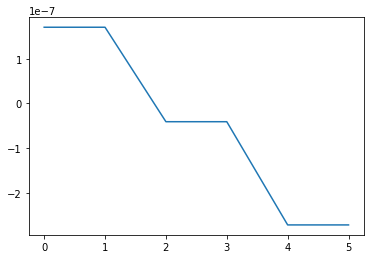

In [28]:
plt.plot(attributions_occ_words[1:-1])

In [ ]:
def occlude(text):
    # Global BERT mask
    global attention_mask
    # Tokenize and prepare 
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)
    # Detach in case the model is on GPU
    indices = input_ids[0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    # Get occlusion values
    attributions_occ = occ.attribute(inputs=input_ids, 
                                    sliding_window_shapes=tuple([4,]), 
                                    strides=3, 
                                    baselines=None, 
                                    target=None, 
                                    additional_forward_args=None, 
                                    perturbations_per_eval=1, 
                                    show_progress=False)
    # Sum the matrices
    attributions_occ_sum = summarize_attributions_occ(attributions_occ)
    # Extract the words
    attributions_occ_words, words = token_to_words(attributions_occ_sum, all_tokens)
    # NLP (Skip tokens)
    doc = nlp(' '.join(words[1:-1]))
    # Init list
    PoS = []
    # Loop over the tokens
    for token, occ_att in zip(doc, attributions_occ_words[1:-1]):
        # Append to list
        PoS.append((token.text, token.pos_, token.dep_,  occ_att))
    
    return PoS

### Part of Speech

In [ ]:
text_list = bird_traits_dict[common_birds[0]]
#text_list = bird_traits__dict[common_birds[0]]

In [ ]:
Pos_list = [occlude(text) for text in tqdm(text_list)]

In [ ]:
for sentence in Pos_list[0:10]:
    words = [item[0] for item in sentence]
    attribution_occlus = [item[3] for item in sentence]
    string = colorize(attribution_occlus, words)
    display(HTML(string))
    print('\n')

In [ ]:
# Flatten the list
flat_list = []
for idx, sublist in enumerate(Pos_list):
    for item in sublist:
        flat_list.append((idx, item[0], item[1], item[2], item[3]))
# Create DF        
df = pd.DataFrame(flat_list, columns=['Sentence', 'Word', 'PoS', 'Dep', 'Occlusion'])
# Melt the DF
df_melt = df.melt(id_vars=['PoS'], value_vars=['Occlusion'])

In [ ]:
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(8, 4))
    sns.despine(bottom=True, left=True)

    sns.stripplot(x="value", y="PoS",
                  data=df_melt, dodge=True, alpha=.25, zorder=1)

    sns.pointplot(x="value", y="PoS",
                  data=df_melt, dodge=.4,
                  join=False, palette="dark",
                  markers="d", scale=.75, ci=None)

In [ ]:
#df[(df['Sentence'] == 23)]

In [ ]:
'''
#### VERSION I
species = common_birds[0]

species_focus = collections.defaultdict(list)

for idx in tqdm(df['Sentence'].unique()):
#for idx in range(22, 24):
    doc = nlp(text_list[idx])
    #print(doc)
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    #print(words)
    #print(words)
    traits =  set(words) & set(parts)
    #print(traits)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:
            for token in doc:
                if token.lemma_.lower() == trait or token.text.lower() == trait:
                    # Reconstruct compounds:
                    if doc[token.i - 1].dep_ == 'compound':
                        span = doc[token.i - 1 : token.i + 1]
                    elif doc[token.i - 2].dep_ == 'compound':
                        span = doc[token.i - 2 : token.i + 1]
                    else:
                        span = doc[token.i]
            
            #print(span, )
            
            if len((span.text.split())) > 1:
                # Use the root of the span in case of compounds
                children = [child.text.lower() for child in span[-1].subtree if child != span[-1]]
            else:
                # Get the subtree of the found span
                children = [child.text.lower() for child in span.subtree if child != span]
        
            #print(children)
            # Get the indices
            indices = df[(df['Sentence'] == idx) & 
                         (df['Word'].isin(children)) & 
                         (df['PoS'].isin(['ADJ', 'ADV', 'VERB']))]\
                        ['Occlusion'].sort_values(ascending=False)

            # Init list
            candidates = []
            for df_idx in indices.index:
                # Get the adjective of the trait
                candidates.append(df.iloc[df_idx].Word)
            # Append
            species_focus[species].append((idx, span.lemma_.lower(), tuple(candidates)))
            # extract data from whole frase to get some information
            if not candidates:
                #print('asd')
                # Get the indices
                indices = df[(df['Sentence'] == idx) & 
                             (df['PoS'].isin(['ADJ', 'ADV', 'VERB']))]\
                            ['Occlusion'].sort_values(ascending=False)
                # Init list
                candidates = []
                for df_idx in indices.index:
                    # Get the adjective of the trait
                    candidates.append(df.iloc[df_idx].Word)
                # Append
                species_focus[species].append((idx, span.lemma_.lower(), tuple(candidates)))
        #except:
            #print(text_list[idx])
'''

In [ ]:
text_list[50]

In [ ]:
### VERSION II
species = common_birds[0]

species_focus = collections.defaultdict(list)

for idx in tqdm(df['Sentence'].unique()):
#for idx in range(50, 51):
    doc = nlp(text_list[idx])
    if len(doc) <= 3:
        continue
    # Check single
    words = [chunk.root.lemma_.lower() for chunk in doc.noun_chunks] 
    # Check multiple
    words += [chunk.root.text.lower() for chunk in doc.noun_chunks]
    # Drop duplicate
    words = list(set(words))
    #print(words)
    #print(words)
    traits =  set(words) & set(parts)
    #print(traits)
    if traits:
        # Yield the traits
        trait_list = list(traits)
        #print(trait_list)
        for trait in trait_list:
            for token in doc:
                if token.lemma_.lower() == trait or token.text.lower() == trait:
                    # Reconstruct compounds:
                    if doc[token.i - 1].dep_ == 'compound':
                        span = doc[token.i - 1 : token.i + 1]
                    elif doc[token.i - 2].dep_ == 'compound':
                        span = doc[token.i - 2 : token.i + 1]
                    else:
                        span = doc[token.i]           
            
        if len((span.text.split())) > 1:
            # Use the root of the span in case of compounds
            children = [child for child in span[-1].children if child != span[-1]]
        else:
            # Get the subtree of the found span
            children = [child for child in span.children if child != span]
            
            
        #print(len(children))
        if len(children) <= 1:
            if len((span.text.split())) > 1:
                # Use the root of the span in case of compounds
                parent = next(child for child in span[-1].ancestors if child != span[-1])
                
            else:
                # Get the subtree of the found span
                parent = next(child for child in span.ancestors if child != span)
            root = next(token for token in doc if token.dep_ == 'ROOT')
            children = [child for child in root.children]
            #children = [child for child in parent.children]
            
        # Reconstruct the subtrees:
        subtree_current_sum = float('-inf')
        subtree_current_text = ''
        for child in children:
            #print(child)
            # QUICK FIX
            # Skips compound children for now
            if child.dep_ == 'compound':
                continue
            subtree = doc[child.left_edge.i : child.right_edge.i + 1]
            #print(subtree)
            subtree_sum = df[(df['Sentence'] == idx) & (df['Word'].isin([t.text for t in subtree]))]['Occlusion'].mean()
            #print(subtree_sum)
            if subtree[-1].is_punct:
                continue
            if subtree[-1].pos_ == 'CCONJ':
                continue
            if subtree_sum > subtree_current_sum:
                subtree_current_sum = subtree_sum
                subtree_current_text = subtree.text
                #print(subtree, subtree_sum)

        species_focus[species].append((idx, span.lemma_.lower(), subtree_current_text.lower()))
            

In [ ]:
children

In [ ]:
species_focus

In [ ]:
displacy.render(doc)

In [ ]:
description_BOW_dict = collections.defaultdict(list)

for bird in species_focus.keys():
    for focus in species_focus[bird]:
        try:
            #description_BOW_dict[bird].append((focus[1], focus[2][0]))
            description_BOW_dict[bird].append((focus[1], focus[2]))
        except:
            continue

In [ ]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [ ]:
source   = []
relation = []
target   = []

test = list(set(description_BOW_dict[common_birds[0]]))

for triple in test:
    if not all(triple):
        continue
    # Quick FIX
    source.append(common_birds[0])
    relation.append('has part')
    target.append(triple[0])
    
    
    source.append(triple[0])
    relation.append('be')
    target.append(triple[1])
    
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation})

In [ ]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(25, 25))
labels = dict(zip(list(zip(kg_df.source, kg_df.target)),
                  kg_df['edge'].tolist()))
pos = nx.spring_layout(G, k = 1)
nx.draw(G, with_labels=True, node_size=2500, pos=graphviz_layout(G))
nx.draw_networkx_edge_labels(G, pos=graphviz_layout(G), edge_labels=labels,
                                 font_color='red')
plt.show()
#plt.savefig('plot.pdf', format='pdf', dpi=1200, bbox_inches='tight')

# Get Annotations

In [ ]:
# Open the text file
location = "../data/external/CUB_200_2011/attributes.txt"
with open(location) as f:
    lines = f.readlines()

In [ ]:
attribute_list = []

# Create a DF with attributes
for line in lines:
    line = line.strip()
    attributes = line.split()[1].split('::')
    part = attributes[0]
    adjective = attributes[1]
    attribute_list.append((part, adjective))
    
# Create DF        
df_attributes = pd.DataFrame(attribute_list, columns=['Part', 'Adj'])
# Reset the index
df_attributes.index = np.arange(1, len(df_attributes)+1)

In [ ]:
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt"
with open(location) as f:
    lines = f.readlines()
# Open the text file
location = "../data/external/CUB_200_2011/CUB_200_2011/images.txt"
with open(location) as f:
    img_ids = f.readlines()

In [ ]:
# Create DF will all present parts
CUB_dict = collections.defaultdict(list)
# Loop over lines
for line in tqdm(lines):
    data = line.split()
    # Skip non present
    if not int(data[2]):
        continue
    # Skip uncertain things
    if int(data[3]) < 3:
        continue
    # Otherwise append
    #print(CUB[int(img_ids[int(data[0])].split()[1][0:3]) - 1], data)
    CUB_dict[CUB[int(img_ids[int(data[0])-1].split()[1][0:3]) - 1]].append((df_attributes.loc[int(data[1]), ][0], df_attributes.loc[int(data[1]), ][1]))

In [ ]:
# Drop duplicates
for bird in CUB_dict.keys():
    CUB_dict[bird] = list(set(CUB_dict[bird]))

In [ ]:
description_CUB_dict = collections.defaultdict(list)
# Rewrite the sentence
for (part, adjective) in CUB_dict[common_birds[0]]:
    part = part[4:].replace('_', ' ')

    description_CUB_dict[common_birds[0]].append((part, adjective))

In [ ]:
for (part, adjective) in description_CUB_dict[common_birds[0]]:
    if part.startswith('crown'):
        print(part, adjective)

In [ ]:
CUB_dict[common_birds[2]]

# Similarity

In [ ]:
from build_features import similarity_matrix as vector_values
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
description_BOW_dict[common_birds[0]].sort()
description_CUB_dict[common_birds[0]].sort()

In [ ]:
#description_BOW_dict

In [ ]:
# Comparison
CUB_part = []
BOW_part = []
for (part, adjective) in description_CUB_dict[common_birds[0]]:
    part = part.replace('color', '').strip()
    if part.startswith('crown'):
        CUB_part.append(adjective)
for (part, adjective) in description_BOW_dict[common_birds[0]]:
    if part.startswith('crown'):
        BOW_part.append(adjective)

In [ ]:
vv_BOW = vector_values(CUB_part)

In [ ]:
vv_CUB = vector_values(BOW_part)

In [ ]:
matrix = cosine_similarity(vv_BOW, vv_CUB)

In [ ]:
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(len(BOW_part), len(CUB_part)))
    ax = sns.heatmap(matrix, 
                     #mask=mask, 
                     square=True,
                     annot=True,
                     cbar=False,
                     cmap=cmap,
                     linewidths=.5,)
    
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right", fontsize=11)
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right", fontsize=11)


#f.suptitle('Similarity Matrix', fontsize=13)
#f.savefig('similarity_matrix.pdf', format='pdf', dpi=1200, bbox_inches='tight')

In [ ]:
print(CUB_part[0])
print(BOW_part[5])

In [ ]:
print(CUB_part)
print(BOW_part)

In [ ]:
sents[36]

In [ ]:
matrix

In [ ]:
description_BOW_dict[birds_list[0]][0:15]

In [ ]:
birds_list